In [3]:
!pip install duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.7 MB/s eta 0:00:00


Saving imagem_2025-08-29_165741187.png to imagem_2025-08-29_165741187.png
14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Classe detectada: analog_clock
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/tmp/ipython-input-295377442.py:36: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  ddgs = DDGS()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-awa

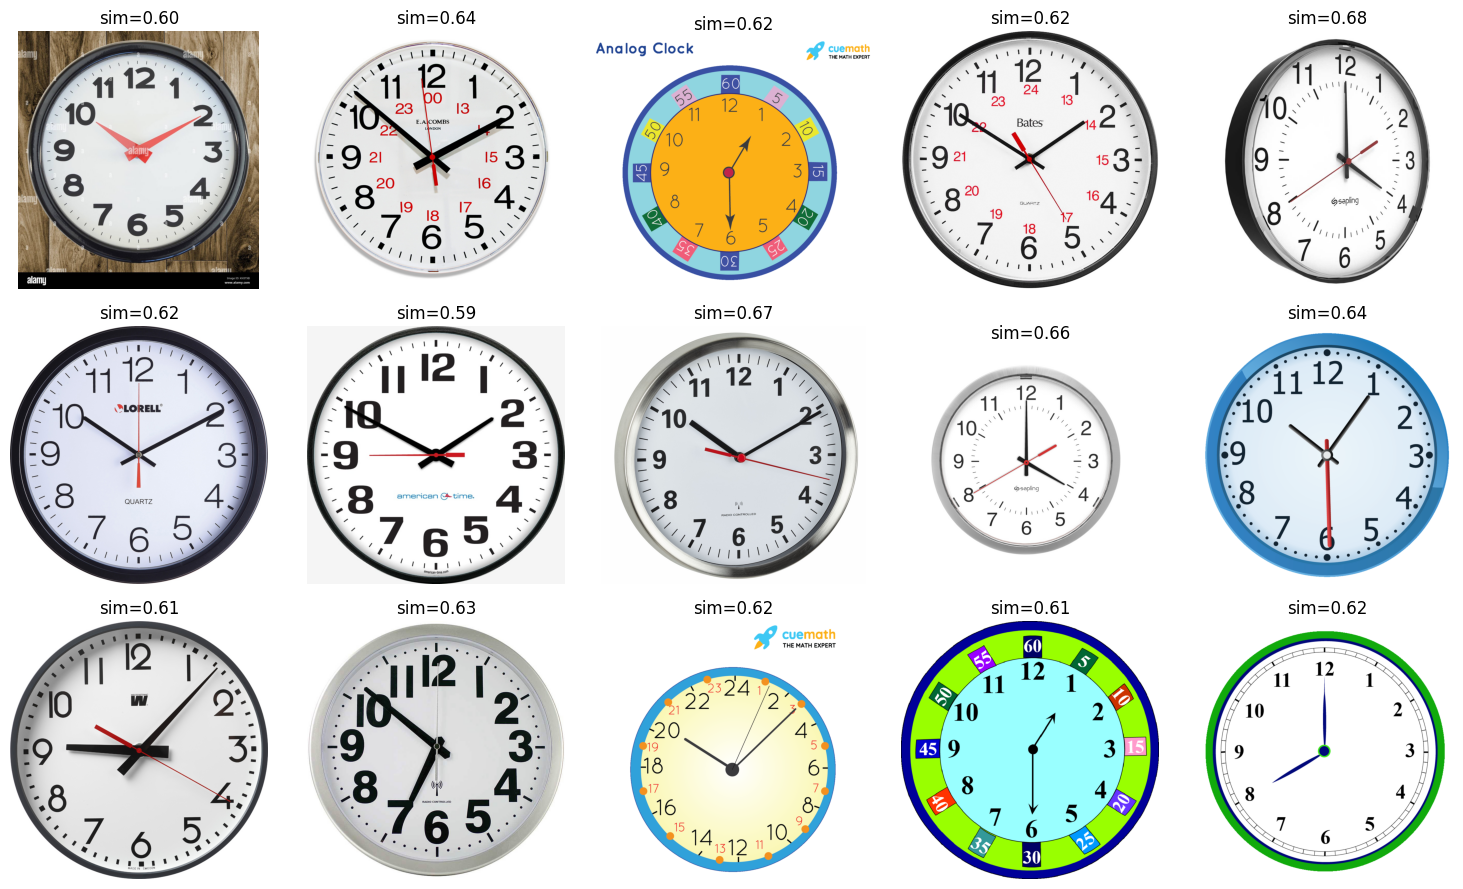

As 3 imagens mais parecidas foram salvas em: ['results/result_5.jpg', 'results/result_8.jpg', 'results/result_9.jpg']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [5]:
# Instalar dependências
!pip install duckduckgo-search tensorflow pillow requests matplotlib

import os
import requests
from duckduckgo_search import DDGS
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2, resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet

from google.colab import files

# === 1. Classificação da imagem de input ===
def classify_image(img_path):
    model = mobilenet_v2.MobileNetV2(weights="imagenet")
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_mobilenet(x)

    preds = model.predict(x, verbose=0)
    decoded = decode_predictions(preds, top=3)[0]
    return decoded  # lista de (class_id, class_name, score)


# === 2. Buscar imagens no DuckDuckGo (nova API) ===
def search_images(query, num=15):
    ddgs = DDGS()
    results = ddgs.images(keywords=query, max_results=num)
    urls = [r['image'] for r in results]
    return urls


# === 3. Extrair embeddings com ResNet50 ===
def get_embedding(img):
    model = resnet50.ResNet50(weights="imagenet", include_top=False, pooling="avg")
    img = img.resize((224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_resnet(x)
    features = model.predict(x, verbose=0)
    return features.flatten()


# === 4. Baixar imagens, calcular similaridade e plotar ===
def download_and_rank(urls, input_embedding, out_dir="results"):
    os.makedirs(out_dir, exist_ok=True)
    scored = []
    all_images = []

    for i, url in enumerate(urls):
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")

            # extrai embedding
            emb = get_embedding(img)

            # similaridade coseno
            sim = np.dot(input_embedding, emb) / (np.linalg.norm(input_embedding) * np.linalg.norm(emb))

            path = os.path.join(out_dir, f"result_{i+1}.jpg")
            img.save(path)

            scored.append((sim, path))
            all_images.append((img, sim))

        except Exception as e:
            print(f"Erro ao processar {url}: {e}")
            continue

    # ordenar por similaridade (decrescente)
    scored.sort(key=lambda x: x[0], reverse=True)
    top3 = [p for _, p in scored[:3]]

    # === Plotar todas as imagens baixadas ===
    cols = 5
    rows = int(np.ceil(len(all_images) / cols))
    plt.figure(figsize=(15, 3 * rows))

    for i, (img, sim) in enumerate(all_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"sim={sim:.2f}")

    plt.tight_layout()
    plt.show()

    return top3


# === Execução principal no Colab ===
uploaded = files.upload()
input_image = list(uploaded.keys())[0]

# 1. Classificar
classes = classify_image(input_image)
main_class = classes[0][1]  # pega o nome da classe mais provável
print(f"Classe detectada: {main_class}")

# 2. Extrair embedding da imagem de input
input_img = Image.open(input_image).convert("RGB")
input_embedding = get_embedding(input_img)

# 3. Buscar imagens similares online
urls = search_images(main_class, num=15)

# 4. Baixar, calcular similaridade, plotar e retornar top-3
top3 = download_and_rank(urls, input_embedding)

print("As 3 imagens mais parecidas foram salvas em:", top3)
